In [1]:
import torch

if torch.cuda.get_device_capability() < (7, 5):
  raise ValueError(f"You got a GPU with capability {torch.cuda.get_device_capability()}, need at least (7, 5)")
else: print("OK")

OK


In [2]:
%pip install -q bitsandbytes==0.37.0 transformers==4.27.4 datasets==2.7.0 accelerate==0.18.0 loralib==0.1.1 peft==0.3.0.dev0

Note: you may need to restart the kernel to use updated packages.


#### Load model

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
from accelerate import init_empty_weights, infer_auto_device_map

CACHE_DIR = '/media/tfsservices/DATA/NLP/cache/'
MODEL_NAME = "EleutherAI/gpt-neox-20B"
# MODEL_NAME = "gpt2-large"
# MODEL_NAME = "facebook/opt-30b"


config = AutoConfig.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
with init_empty_weights():
    model = AutoModelForCausalLM.from_config(config)



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# device_map = infer_auto_device_map(model, dtype="float16")

In [5]:
# print(device_map)

In [6]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_8bit=True,        # bitsandbytes lib required (convert the loaded model into mixed-8bit quantized model.)
    device_map='auto',
    # device_map=device_map,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR)      # path to a directory in which a downloaded pretrained model
    # low_cpu_mem_usage=True,   # loads the model using ~1x model size CPU memory
    # offload_state_dict=True)  # temporarily offload the CPU state dict to the hard drive to avoid getting out of CPU RAM
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 46/46 [00:26<00:00,  1.74it/s]


#### Post-processing on the model

In [7]:
model.eval()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50432, 6144)
    (layers): ModuleList(
      (0-43): 44 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((6144,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((6144,), eps=1e-05, elementwise_affine=True)
        (attention): GPTNeoXAttention(
          (rotary_emb): RotaryEmbedding()
          (query_key_value): Linear8bitLt(in_features=6144, out_features=18432, bias=True)
          (dense): Linear8bitLt(in_features=6144, out_features=6144, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear8bitLt(in_features=6144, out_features=24576, bias=True)
          (dense_4h_to_h): Linear8bitLt(in_features=24576, out_features=6144, bias=True)
          (act): FastGELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((6144,), eps=1e-05, elementwise_affine=True)
  )
  (embed_out): Linear(in_features=6144, out_features=50432, bias=Fals

In [8]:
# for module in model.modules():
#     if isinstance(module, bnb.nn.Linear8bitLt):
#         module.state.memory_efficient_backward = True

for param in model.parameters():
    param.requires_grad = False  # freeze the model - train adapters later
    if param.ndim == 1:
        param.data = param.data.to(torch.float32) # cast the small parameters (e.g. layernorm) to fp32 for stability

model.gradient_checkpointing_enable()  # reduce number of stored activations
# model.gpt_neox.project_in = lambda x: x.requires_grad_(True)
model.enable_input_require_grads()

# cast model outputs to float32 to unfuck the top-k sampler
class CastOutputToFloat(nn.Sequential):
    def forward(self, x): return super().forward(x).to(torch.float32)
model.embed_out = CastOutputToFloat(model.embed_out)
# model.lm_head = CastOutputToFloat(model.lm_head)

#### Apply LoRA

In [9]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [10]:
from peft import LoraConfig, get_peft_model 

config = LoraConfig(
    r=8, ## can be reduced to 8
    lora_alpha=32,
    target_modules=["query_key_value" ],
    # target_modules=["c_attn" ],
    # target_modules=["k_proj", "v_proj", "q_proj" ],
    lora_dropout=0.05, ## 0.05
    bias="none",
    task_type="CAUSAL_LM",
    inference_mode=False # test,
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 8650752 || all params: 20563218432 || trainable%: 0.04206905659543013


In [11]:
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoXForCausalLM(
      (gpt_neox): GPTNeoXModel(
        (embed_in): Embedding(50432, 6144)
        (layers): ModuleList(
          (0-43): 44 x GPTNeoXLayer(
            (input_layernorm): LayerNorm((6144,), eps=1e-05, elementwise_affine=True)
            (post_attention_layernorm): LayerNorm((6144,), eps=1e-05, elementwise_affine=True)
            (attention): GPTNeoXAttention(
              (rotary_emb): RotaryEmbedding()
              (query_key_value): MergedLinear8bitLt(
                in_features=6144, out_features=18432, bias=True
                (lora_dropout): Dropout(p=0.05, inplace=False)
                (lora_A): Linear(in_features=6144, out_features=16, bias=False)
                (lora_B): Conv1d(16, 12288, kernel_size=(1,), stride=(1,), groups=2, bias=False)
              )
              (dense): Linear8bitLt(in_features=6144, out_features=6144, bias=True)
            )
            (mlp): GPTNeoXMLP(
    

#### Fine-tune model

#### Prepare dataset

In [12]:
# from datasets import load_dataset

# dataset = load_dataset("csv", data_files="./datasets/armm.csv")['train']

In [13]:
import pandas as pd
# df = pd.read_csv('datasets/wm.csv')
df = pd.read_csv('datasets/wm_large.csv')
df.head()

,text,tag
0,"Hi {Client}, \n\nHope all is well. I am Stacey...",Purchase Inquiry
1,Hi \nThank you for contacting CAE. What’s the...,Purchase Inquiry
2,"Hi {MakeModel}, \nThank you for your inquiry. ...",Purchase Inquiry
3,"Hi {Client}, \n\nThank you for contacting CAE....",Purchase Inquiry
4,"Hi Sir, \n\nHope this mail finds you well, I r...",Purchase Inquiry


In [14]:
df['tokens'] = [len(t.split()) for t in df['text']]

In [15]:
# MIN_TOKENS_COUNT = 100
# df = df[df['tokens']>MIN_TOKENS_COUNT]
df.head()

,text,tag,tokens
0,"Hi {Client}, \n\nHope all is well. I am Stacey...",Purchase Inquiry,103
1,Hi \nThank you for contacting CAE. What’s the...,Purchase Inquiry,295
2,"Hi {MakeModel}, \nThank you for your inquiry. ...",Purchase Inquiry,166
3,"Hi {Client}, \n\nThank you for contacting CAE....",Purchase Inquiry,296
4,"Hi Sir, \n\nHope this mail finds you well, I r...",Purchase Inquiry,243


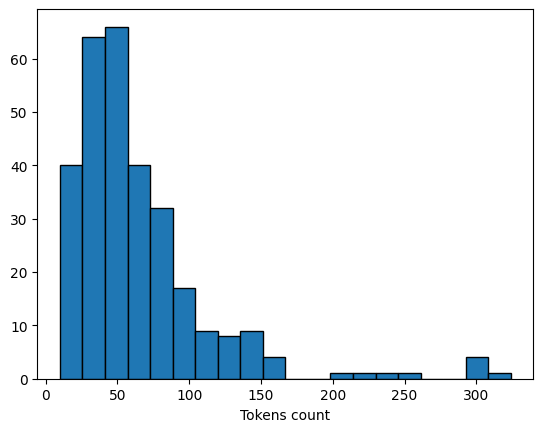

In [16]:
import matplotlib.pyplot as plt

plt.hist(df['tokens'], edgecolor='black', bins=20)
plt.xlabel('Tokens count')
plt.show()

In [17]:
df['prices'] = [t.count('{Price}') for t in df['text']]
print(f"Texts with prices: {round(len(df[df['prices']>0])/df['prices'].count()*100, 2)} %")

Texts with prices: 5.37 %


In [18]:
df['equip_details'] = [t.count('{EquipDetails}') for t in df['text']]
print(f"Texts with equipment details: {round(len(df[df['equip_details']>0])/df['equip_details'].count()*100, 2)} %")


Texts with equipment details: 25.5 %


In [19]:
df['questions'] = [t.count('?') for t in df['text']]
print(f"Texts with questions: {round(len(df[df['questions']>0])/df['questions'].count()*100, 2)} %")

Texts with questions: 73.49 %


In [20]:
df['make_models'] = [t.count('{MakeModel}') for t in df['text']]
print(f"Texts with mentioned Make/Models: {round(len(df[df['make_models']>0])/df['make_models'].count()*100, 2)} %")

Texts with mentioned Make/Models: 55.03 %


In [21]:
# def create_prompt_column(raw):

#     prompt = f"Generate text in {raw['tokens']} tokens for {raw['tag']}"

#     if (raw['prices'] > 0):
#         prompt += " with price"

#     if (raw['questions'] > 0):
#         prompt += " with questions"

#     prompt += f":\n{raw['text']}\n\n###\n"

#     return prompt

def create_prompt_column(raw):

    return f"Q: Generate for {raw['tag']}:\nA: {raw['text']}\n###\n"

In [22]:
df['prompt'] = df.apply(create_prompt_column, axis=1)

In [24]:
df.head()

,text,tag,tokens,prices,equip_details,questions,make_models,prompt
0,"Hi {Client}, \n\nHope all is well. I am Stacey...",Purchase Inquiry,103,0,1,7,0,Q: Generate for Purchase Inquiry:\nA: Hi {Clie...
1,Hi \nThank you for contacting CAE. What’s the...,Purchase Inquiry,295,0,0,9,2,Q: Generate for Purchase Inquiry:\nA: Hi \nTh...
2,"Hi {MakeModel}, \nThank you for your inquiry. ...",Purchase Inquiry,166,0,0,2,2,Q: Generate for Purchase Inquiry:\nA: Hi {Make...
3,"Hi {Client}, \n\nThank you for contacting CAE....",Purchase Inquiry,296,0,0,9,2,Q: Generate for Purchase Inquiry:\nA: Hi {Clie...
4,"Hi Sir, \n\nHope this mail finds you well, I r...",Purchase Inquiry,243,0,1,5,0,"Q: Generate for Purchase Inquiry:\nA: Hi Sir, ..."


In [25]:
dataset_path = './datasets/wm_ext.csv'
df.to_csv(dataset_path)

In [26]:
from datasets import load_dataset

dataset_path = './datasets/wm_ext.csv'

dataset = load_dataset("csv", data_files=dataset_path)
tokenizer.pad_token = tokenizer.eos_token

dataset = dataset.map(lambda samples: tokenizer(samples['prompt']), batched=True)

ADAPTER_NAME = "adapters/gpt-neox-20B-wm_cmd"
# ADAPTER_NAME = "adapters/gpt-2-wm_cmd"
# ADAPTER_NAME = "adapters/opt-30b-wm_cmd"
# ADAPTER_NAME = "adapters/celebras-gpt-13B-wm_cmd"

Using custom data configuration default-a56d2e4742a12389


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1389.76it/s]
Generating train split: 0 examples [00:00, ? examples/s]/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:714: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Dataset csv downloaded and prepared to /home/tfsservices/.cache/huggingface/datasets/csv/default-a56d2e4742a12389/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 34.78ba/s]


In [27]:
import transformers
from transformers import Trainer, DataCollatorForLanguageModeling, TrainingArguments

trainer = Trainer(
    model=model, 
    train_dataset=dataset['train'],
    args=TrainingArguments(
        per_device_train_batch_size=4, 
        gradient_accumulation_steps=4,
        # per_device_train_batch_size=1, 
        # gradient_accumulation_steps=1,
        warmup_steps=10, 
        # warmup_steps=2, 
        # max_steps=20, 
        # max_steps=10, 
        max_steps=50, 
        # max_steps=50, 
        learning_rate=2e-4, 
        fp16=True,
        logging_steps=5, 
        # save_steps=100,
        output_dir='outputs_marketing'),
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False))

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/transformers/models/gpt_neox/modeling_gpt_neox.p

Step,Training Loss
5,2.997000
10,2.743600
15,2.226700
20,1.797100
25,1.714500
30,1.692000
35,1.656000
40,1.504900
45,1.604900


TrainOutput(global_step=50, training_loss=1.9478308963775635, metrics={'train_runtime': 606.0379, 'train_samples_per_second': 1.32, 'train_steps_per_second': 0.083, 'total_flos': 1.7791041215102976e+16, 'train_loss': 1.9478308963775635, 'epoch': 2.67})

#### Save LoRA adapter

In [52]:
# ADAPTER_NAME = "lora_adapters-6.7b"
# ADAPTER_NAME = "lora_adapters-13b"
# ADAPTER_NAME = "adapters/gpt-j-6B-armm"
# ADAPTER_NAME = "adapters/gpt-j-6B-wm"


model.save_pretrained(ADAPTER_NAME)

#### Test generation

In [28]:
model.inference_mode=True
model.config.use_cache = False

In [29]:
def generate_marketing(max_length = 150):
    
    batch = tokenizer("Q: Generate for Purchase Inquiry \nA:", return_tensors='pt').to('cuda')

    # with torch.no_grad():
    with torch.cuda.amp.autocast():
        output_tokens = model.generate(**batch, min_length=30, max_length=max_length, do_sample=True, pad_token_id=tokenizer.eos_token_id)

    print('\n\n', tokenizer.decode(output_tokens[0].cpu().numpy()))

In [30]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):

    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = stops
        self.ENCOUNTERS = encounters

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        stop_count = 0
        for stop in self.stops:
            stop_count = (stop == input_ids[0]).sum().item()

        if stop_count >= self.ENCOUNTERS:
            return True
        return False    

stop_words_ids = [tokenizer(stop_word, return_tensors='pt')['input_ids'].squeeze() for stop_word in ["###"]]
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids, encounters=1)])

In [31]:
def generate(prompt: str, max_length=250):

    batch = tokenizer(prompt, return_tensors="pt").to('cuda')

    # input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    # with torch.no_grad():
    with torch.cuda.amp.autocast():
        # outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_length=max_length, do_sample=True, )
        outputs = model.generate(**batch,
                                # early_stopping=True, 
                                # num_beams=6,
                                # num_beam_groups = 3,
                                no_repeat_ngram_size = 4,
                                temperature=0.9,
                                top_k=10,
                                # top_p=0.8,
                                penalty_alpha=0.6,
                                # repetition_penalty = 1.05,
                                do_sample=True,

                                max_length = max_length,
                                pad_token_id=tokenizer.eos_token_id,
                                stopping_criteria=stopping_criteria,
                                
                                # use_cachе=True,
                                # output_scores=True,
                                # return_dict_in_generate=True).detach()
        )
        generated = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0]
        print(f"tokens: {len(generated.split())}")
        print(f"text: {generated}")

In [32]:
# generate(prompt='Q: Generate Requirement \nA:', max_length=250)
generate(prompt='Q: Generate for Purchase Inquiry \nA:', max_length=250)
# generate(prompt='Q: Generate text  \nA:', max_length=250)
# generate_marketing()
# generate(prompt='Hi {Client}:', max_length=250)

/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/transformers/generation/utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


tokens: 37
text: Q: Generate for Purchase Inquiry 
A: {Client}, 
  
Thank you for reaching out with this inquiry.  
I understand that you are looking to purchase some {MakeModel}.  
Please share the technical and functional information you have.  
   {EquipDetails}

{Signature}
###


In [33]:
# generate(prompt='Q: Generate Requirement \nA:', max_length=250)
# generate(prompt='Generate text in 150 tokens for Purchase Inquiry with questions:', max_length=250)
generate(prompt='Q: Generate for Purchase Inquiry \nA:',max_length=512)

tokens: 34
text: Q: Generate for Purchase Inquiry 
A: {Client}, 

Thank you for reaching out. Please allow me to check availability on the unit first. 
Can you please provide me the following details?
{EquipDetails}

{BestRegards}
{Signature}
###


In [34]:
# generate(prompt='Q: Generate Listing \nA:', max_length=450)
# generate(prompt='Generate text for Purchase Inquiry :', max_length=250)
generate(prompt='Q: Generate for Purchase Inquiry \nA:', max_length=512)

tokens: 63
text: Q: Generate for Purchase Inquiry 
A: Hello {Client}, 
We received your inquiry for {MakeModel} with asking price {Price}. 
Can we please have the information of your purchase requirement? 
Do you have this for purchase or for leasing? 
How many are you looking and when can you get this machine? 
Thank you and we will be waiting for your reply. 

Best Regards, 
{Signature}
###


In [35]:
generate(prompt='Q: Generate for New Listing \nA:', max_length=512)

tokens: 50
text: Q: Generate for New Listing 
A: {Client} 
  
Hello {Trader},

Thank you for reaching out to us regarding the {MakeModel} {Category}. 
As you may know this unit has been listed with a previous owner. The system is still available. Are you looking for this specific model number? 
   {EquipDetails}

Best, 
{Signature}
###


In [36]:
generate(prompt="Q: Generate for New Listing \nA:", max_length=512)

tokens: 51
text: Q: Generate for New Listing 
A: Hi {Client}, 
  
Thank you for reaching out and showing your system for sale. Please let me know what information we need about the system and the reason you’re selling. 
   Also, I have attached two photos of the system to help familiarize the potential buyer. 
  
  ###


In [37]:
generate(prompt="Q: Generate for New Listing \nA:", max_length=512)

tokens: 55
text: Q: Generate for New Listing 
A: Hi {Client}, 

Thanks for reaching out. 
I’m following up on your inquiry. 

Are you looking for a used {MakeModel} or a new one? 
I also have other machines and tooling that may be of interest. 

What do you expect to pay for each machine or tooling? 

Thanks. 

{Signature} 

###


In [77]:
# generate(prompt="Dear {FirstName} ", max_length=250)
# generate(prompt='Q: Generate for Purchase Inquiry \nA:', max_length=250)

In [78]:
# generate(prompt="Q: Generate for New Listing \nA:", max_length=250)

In [79]:
# generate(prompt="Requirement: Hi {FirstName} ", max_length=200)
# generate(prompt="Requirement: ", max_length=200)
# generate(prompt="Hi {FirstName} ", max_length=250)
# generate(prompt="Q: Generate for Purchase Inquiry \nA: ", max_length=450)

In [80]:
# generate(prompt="Q: Generate for New Listing \nA:", max_length=250)

In [81]:
# generate(prompt="Inquiry: Hi {FirstName} ", max_length=200)